In [ ]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='388f960b-09fa-46ab-91c1-61629024f5fc', project_access_token='p-84846afe01e1708a850272092ccc7029ccd50410')


# Promote financial products to bank customers 

### Combine Predictive and Prescriptive analytics

Machine Learning is a powerful technology that extracts information from historical data to give you insight, e.g. to classify customers, predict behaviors, forecast demands. The next actions that are best to take are more difficult to define when different constraints and objectives are to be taken into account between the different decisions.

Decision Optimization is a powerful technology that uses the outcome of Machine Learning and prescribes the best set of next decisions taking into account laws, constraints, regulations and trade-offs between different business objectives.

### The industry case

In 2018, a retail bank sold several products (mortgage accounts, savings accounts, and pension accounts) to its customers.
It kept a record of all historical data, and this data is available for analysis and reuse.
Following a merger in 2019, the bank has new customers and wants to launch some marketing campaigns. 

The budget for the campaigns is limited. The bank wants to contact a customer and propose only one product.

The marketing department needs to decide:
   * Who should be contacted?
   * Which product should be proposed?  
   Proposing too many products is counter-productive, so only one product per customer contact is proposed.
   * How a customer should be contacted?  
   There are different ways, with different costs and efficiency.
   * How can they optimally use their limited budget?
   * Are such campaigns profitable?
   
### Predictive and prescriptive workflow

This notebook takes you through the following steps:
* From the historical data, you train a machine learning product-based classifier on a customer profile (age, income, account level, ...) to predict whether a customer would subscribe to a mortgage, savings, or pension account.
* Then, you apply this predictive model to new customer data to predict for each new customer what they might purchase.
* Then, you apply a Decision Optimization model to find out which product should be offered to which customer through which channel.
* The solutions can be displayed and analyzed.


Before executing this notebook on IBM Cloud, you need to:<br>
1) When you import this project on an IBM Cloud environment, a project access token should be inserted at the top of this notebook as a code cell. <br>
If you do not see the cell above, Insert a project token: Click on **More -> Insert project token** in the top-right menu section and run the cell. <br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
2) You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>


### Table of contents:

*  [Understand the historical data](#Understand-the-historical-data)
*  [Train a model to predict customer behavior](#Train-a-model-to-predict-customer-behavior)
*  [Predict the new customer behavior](#Predict-the-new-customer-behavior)
*  [Prescribe the best business decisions](#Prescribe-the-best-business-decisions)
*  [Run some what-if analysis](#Run-some-what-if-analysis)
*  [Conclusion](#Conclusion)

**Note**: Make sure you run the code cell at the top of this notebook. All projects in IBM Watson Studio have an authorization token that is used to enable access to project assets, for example data assets and connections, and is used by platform APIs. This token is called the project access token. The code to use this token was added to the notebook for you during the project template import.


# Important

Decision Optimization engines are preinstalled in all Watson Studio Jupyter environments:
- In regular **Python 3.8** environments, the CPLEX Community Edition is available with a limit of 1000 constraints and 1000 variables.
- The **Python 3.8 + DO** environment includes the CPLEX Commercial Edition with unlimited capabilities.


With `USE_SMALL_DATA_SET` variable set to `True`, the smaller model can be executed in a regular Python 3.8 environment. If, however, you want to use the big data set, you must switch to the Python 3.8 + DO environment.

In [1]:
USE_SMALL_DATA_SET = True;

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# Understand the historical data

First, you can load 2018 historical data, analyze it visually, and train a classifier to predict 2019 sales.

### Load the historical customer data with their purchases (Mortgage, Savings, and Pension).

In [3]:
# Get the known behaviors file
known_behaviors = pd.read_csv(project.get_file('known_behaviors.csv'))
known_behaviors.head()

NameError: name 'project' is not defined

### Check the 2018 customers

In [5]:
a = known_behaviors[known_behaviors.Mortgage == 1]
b = known_behaviors[known_behaviors.Pension == 1]
c = known_behaviors[known_behaviors.Savings == 1]
print("Number of clients: %d" %len(known_behaviors))
print("Number of clients predicted to buy mortgage accounts: %d" %len(a))
print("Number of clients predicted to buy pension accounts: %d" %len(b))
print("Number of clients predicted to buy savings accounts: %d" %len(c))

Number of clients: 11023
Number of clients predicted to buy mortgage accounts: 1664
Number of clients predicted to buy pension accounts: 2456
Number of clients predicted to buy savings accounts: 4222


In [6]:
known_behaviors["nb_products"] = known_behaviors.Mortgage + known_behaviors.Pension + known_behaviors.Savings

In [7]:
abc = known_behaviors[known_behaviors.nb_products > 1]
print("You have %d clients who bought several products" %len(abc))
abc = known_behaviors[known_behaviors.nb_products == 3]
print("You have %d clients who bought all the products" %len(abc))

You have 1650 clients who bought several products
You have 123 clients who bought all the products


In [8]:
products = ["Savings", "Mortgage", "Pension"]

### Provide some visual analysis of the historical data

This notebook relies on matplotlib as it is commonly used for simple visualization.

In [9]:
def plot_cloud_points(df):
    figure = plt.figure(figsize=(20, 5))
    my_cm  = ListedColormap(['#bb0000', '#00FF00'])
    axes = {p : ('age', 'income') if p != "Mortgage"else ('members_in_household', 'loan_accounts') for p in products}
    for product in products:
        ax = plt.subplot(1, len(products), products.index(product)+1)
        ax.set_title(product)
        axe = axes[product]
        plt.xlabel(axe[0])
        plt.ylabel(axe[1])
        ax.scatter(df[axe[0]], df[axe[1]], c=df[product], cmap=my_cm, alpha=0.5)

In the following visualization, you can see the behavior of the 2018 customers for the three products.
The green color indicates that a customer bought a product; red indicates a customer did not buy a product.
The depth of the color indicates the number of purchases or non-purchases.

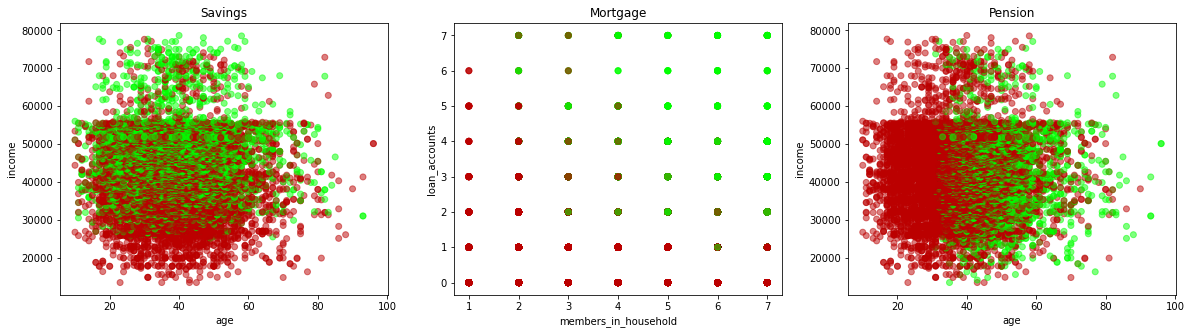

In [10]:
plot_cloud_points(known_behaviors)

### Understanding the 2018 customers
You can see that:
   * The greater a customer's income, the more likely it is that he or she buys a savings account.
   * The older a customer is, the more likely it is that he or she buys a pension account.
   * There is a correlation between the number of people in a customer's household, the number of loan accounts held by the customer, and the likelihood a customer buys a mortgage account. To see the correlation, look at the upper right and lower left corners of the mortgage chart.

# Train a model to predict customer behavior

You can now create and train a machine learning model to predict customer behavior.

### Prepare data and select features to be used

In [11]:
known_behaviors.columns

Index(['customer_id', 'age', 'age_youngest_child', 'debt_equity', 'gender',
       'bad_payment', 'gold_card', 'pension_plan',
       'household_debt_to_equity_ratio', 'income', 'members_in_household',
       'months_current_account', 'months_customer', 'call_center_contacts',
       'loan_accounts', 'number_products', 'number_transactions',
       'non_worker_percentage', 'white_collar_percentage', 'rfm_score',
       'Mortgage', 'Pension', 'Savings', 'nb_products'],
      dtype='object')

Use the following columns as machine-learning features:

In [12]:
cols = ['age', 'income', 'members_in_household', 'loan_accounts']

In [13]:
X = known_behaviors[cols]
ys = [known_behaviors[p] for p in products]

In [14]:
X.head()

,age,income,members_in_household,loan_accounts
0,45,13453,2,4
1,43,13453,2,0
2,23,13453,2,1
3,35,13453,2,1
4,43,14124,3,1


### Create and train one simple model for each product

You are using a standard basic support gradient boosting algorithm to predict whether a customer might buy product A, B, or C.

In [15]:
from sklearn import svm
from sklearn import ensemble

In [16]:
classifiers = []
for i,p in enumerate(products):
    clf = ensemble.GradientBoostingClassifier()
    clf.fit(X, ys[i])
    classifiers.append(clf)

# Predict the new customer behavior

Load new customer data, predict behavior using a trained classifier, and perform some visual analysis.
You have all the characteristics of the new customers, as for the 2018 clients, but the new customers have not yet bought any product.

### Load new customer data

In [17]:
unknown_behaviors = pd.read_csv(project.get_file('unknown_behaviors.csv'))
if USE_SMALL_DATA_SET:
    unknown_behaviors = unknown_behaviors[0:100]
unknown_behaviors.head()    

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score
0,44256,38,11,38,1,0,0,0,58,47958.0,4,41,48,2,1,2,1,9,31,7.949
1,46883,30,1,30,0,0,0,0,55,48606.0,2,23,36,2,4,3,2,11,33,11.437
2,32387,41,13,41,1,0,0,0,59,42152.0,4,39,48,1,0,1,1,11,29,7.462
3,25504,42,14,42,1,0,0,0,57,39788.0,3,21,24,2,3,0,0,15,27,0.000
4,35979,42,14,42,1,0,0,0,53,44365.0,6,41,48,3,2,3,1,5,41,7.806


In [18]:
for c in unknown_behaviors.columns:
    assert c in known_behaviors.columns

In [19]:
to_predict = unknown_behaviors[cols]

In [20]:
print("Number of new customers: %d" %len(unknown_behaviors))

Number of new customers: 100


### Predict behaviors of the new customers

You can simply use the trained models from the previous section.

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
predicted = [classifiers[i].predict(to_predict) for i in range(len(products))]
for i,p in enumerate(products):
    to_predict[p] = predicted[i]
to_predict["id"] = unknown_behaviors["customer_id"]


### Package new data with predictions for optimization

In [23]:
offers = to_predict
offers.head()

,age,income,members_in_household,loan_accounts,Savings,Mortgage,Pension,id
0,38,47958.0,4,1,0,0,0,44256
1,30,48606.0,2,4,0,0,0,46883
2,41,42152.0,4,0,0,0,0,32387
3,42,39788.0,3,3,0,0,0,25504
4,42,44365.0,6,2,0,1,0,35979


### Perform some visual analysis of the predicted data

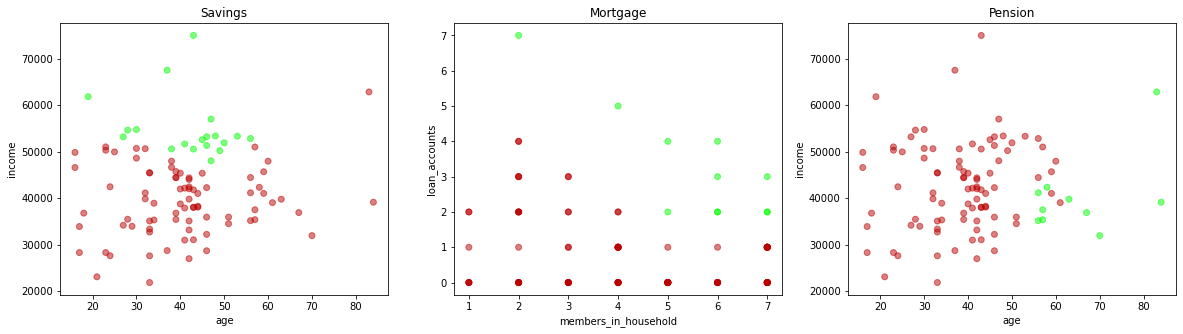

In [24]:
plot_cloud_points(offers)

The predicted data has the same semantics as the base data, with even more clear frontiers:
* for savings, there is a  clear frontier at $50K revenue.
* for pension, there is a clear frontier at 55 years old customers.

The training data contains customers who bought more than one product, take a look at the prediction

In [25]:
a = offers[offers.Mortgage == 1]
b = offers[offers.Pension == 1]
c = offers[offers.Savings == 1]
print("Number of new customers: %d" %len(offers))
print("Number of customers predicted to buy mortgages: %d" %len(a))
print("Number of customers predicted to buy pensions: %d" %len(b))
print("Number of customers predicted to buy savings: %d" %len(c))

Number of new customers: 100
Number of customers predicted to buy mortgages: 11
Number of customers predicted to buy pensions: 10
Number of customers predicted to buy savings: 19


In [26]:
to_predict["nb_products"] = to_predict.Mortgage + to_predict.Pension + to_predict.Savings

abc = to_predict[to_predict.nb_products > 1]
print("It's predicted that %d clients would buy more than one product" %len(abc))
abc = to_predict[to_predict.nb_products == 3]
print("It's predicted that %d clients would buy all three products" %len(abc))

It's predicted that 2 clients would buy more than one product
It's predicted that 0 clients would buy all three products


### What to do next? 

The business goal is to contact the customers to sell them only **one** product, so you cannot select all of them.

Also, you need to determine which is the best contact channel, knowing that some operational constraints might limit how many customers can be contacted through a given channel.

With many candidate customers, several products and channels, and with different constraints a lot of decisions have to be taken.

In addition, as constraints apply between all these numerous decisions (between different product decisions for one customer, different customer/product decisions for one channel, etc.), it is not possible to work out manually the optimal solutions that correspond to the best revenue by looking individually at each possible offer.

This is where Decision Optimization applies.


In [27]:
offers.reset_index(inplace=True)

# Prescribe the best business decisions

* You have a prediction of who might purchase what in the list of new customers.
* You have various contact channels with different costs and effectiveness.
* However, you do not have the budget to contact all of them. 
* Furthermore, if you contact a customer you want to propose only one product per customer.

### Some input data for optimization

You need the different costs and prices of different channels and products.


In [28]:
# How much revenue is earned when selling each product
productValue = [200, 300, 400]
value_per_product = {products[i] : productValue[i] for i in range(len(products))}

# Total available budget
availableBudget = 25000
if USE_SMALL_DATA_SET:
    availableBudget = 1000

# For each channel, cost of making a marketing action and success factor
channels =  pd.DataFrame(data=[("gift", 20.0, 0.20), 
                               ("newsletter", 15.0, 0.05), 
                               ("seminar", 23.0, 0.30)], columns=["name", "cost", "factor"])

offersR = range(0, len(offers))
productsR = range(0, len(products))
channelsR = range(0, len(channels))

### IBM Decision Optimization CPLEX Modeling for Python

The following parts require some Decision Optimization modeling skills.
If you're new to optimization, you may want to go through the free online Decision Optimization tutorials ([CPLEX Part 1](https://ibmdecisionoptimization.github.io/tutorials/html/Linear_Programming.html) and [CPLEX Part 2](https://ibmdecisionoptimization.github.io/tutorials/html/Beyond_Linear_Programming.html)) might help you get a better understanding of Mathematical Optimization.

Create the optimization model to select the best ways to contact customers and stay within the limited budget.

### Set up the prescriptive model

In [29]:
import sys
import docplex.mp
from docplex.mp.model import Model

mdl = Model(name="marketing_campaign", checker='on')

### Define the decision variables
- The integer decision variables `channelVars`, represent whether or not a customer should be made an offer for a particular product via a particular channel.
- The integer decision variable `totaloffers` represents the total number of offers made.
- The continuous variable `budgetSpent` represents the total cost of the offers made.

In [30]:
channelVars = mdl.binary_var_cube(offersR, productsR, channelsR)

### Set up the constraints
- Offer only one product per customer.
- Compute the budget and set a maximum on it.
- Compute the number of offers to be made.
- Ensure at least 10% of offers are made via each channel.

In [31]:
# At most 1 product is offered to each customer
mdl.add_constraints( mdl.sum(channelVars[o,p,c] for p in productsR for c in channelsR) <=1
                   for o in offersR)

# Do not exceed the budget
mdl.add_constraint( mdl.sum(channelVars[o,p,c]*channels._get_value(index=c, col="cost") 
                                           for o in offersR 
                                           for p in productsR 
                                           for c in channelsR)  <= availableBudget, "budget")  

# At least 10% offers per channel
for c in channelsR:
    mdl.add_constraint(mdl.sum(channelVars[o,p,c] for p in productsR for o in offersR) >= len(offers) // 10)

mdl.print_information()

Model: marketing_campaign
 - number of variables: 900
   - binary=900, integer=0, continuous=0
 - number of constraints: 104
   - linear=104
 - parameters: defaults
 - objective: none
 - problem type is: MILP


### Express the objective

You want to maximize expected revenue, so you take into account the predicted behavior of each customer for each product.

In [32]:
obj = 0

for c in channelsR:
    for p in productsR:
        product=products[p]
        coef = channels._get_value(index=c, col="factor") * value_per_product[product]
        obj += mdl.sum(channelVars[o,p,c] * coef* offers._get_value(index=o, col=product) for o in offersR)

mdl.maximize(obj)

### Set some KPIs to be used for reporting

For example, total number of offers, total budget spent, etc.

In [33]:
totaloffers = mdl.sum(channelVars[o,p,c] 
                      for o in offersR
                      for p in productsR 
                      for c in channelsR)
mdl.add_kpi(totaloffers, "nb_offers")

budgetSpent = mdl.sum(channelVars[o,p,c]*channels._get_value(index=c, col="cost") 
                                           for o in offersR 
                                           for p in productsR 
                                           for c in channelsR)
mdl.add_kpi(budgetSpent, "budgetSpent")

for c in channelsR:
    channel = channels._get_value(index=c, col="name")
    kpi = mdl.sum(channelVars[o,p,c] for p in productsR for o in offersR)
    mdl.add_kpi(kpi, channel)

for p in productsR:
    product = products[p]
    kpi = mdl.sum(channelVars[o,p,c] for c in channelsR for o in offersR)
    mdl.add_kpi(kpi, product)

### Solve the Decision Optimization model

In [34]:
mdl.parameters.timelimit = 30
mdl.parameters.threads = 1
mdl.print_information()

Model: marketing_campaign
 - number of variables: 900
   - binary=900, integer=0, continuous=0
 - number of constraints: 104
   - linear=104
 - parameters:
     parameters.threads = 1
     parameters.timelimit = 30.00000000000000
 - objective: maximize
 - problem type is: MILP


In [35]:
s = mdl.solve()
assert s, "No Solution !!!"

In [36]:
print(mdl.get_solve_status())
print(mdl.get_solve_details())

JobSolveStatus.OPTIMAL_SOLUTION
status  = integer optimal solution
time    = 0.0109611 s.
problem = MILP
gap     = 0%



### Display the solution

First look at the overall report.

In [37]:
mdl.report()

* model marketing_campaign solved with objective = 3010.000
*  KPI: nb_offers   = 48.000
*  KPI: budgetSpent = 994.000
*  KPI: gift        = 10.000
*  KPI: newsletter  = 10.000
*  KPI: seminar     = 28.000
*  KPI: Savings     = 26.000
*  KPI: Mortgage    = 12.000
*  KPI: Pension     = 10.000


And the detailed list of prescribed offers

In [38]:
pd.DataFrame( [(channels._get_value(index=c, col="name"), products[p], o) 
          for c in channelsR 
          for p in productsR 
          for o in offersR  if channelVars[o,p,c].solution_value==1],
             columns=["channel", "product", "customer id"])


,channel,product,customer id
0,gift,Savings,11
1,gift,Savings,34
2,gift,Savings,46
3,gift,Savings,47
4,gift,Savings,58
5,gift,Savings,60
6,gift,Savings,63
7,gift,Savings,66
8,gift,Savings,73
9,gift,Savings,82


# Run some what-if analysis

### What if the budget were increased?

If the manager is prepared to increase the allocated budget, they might want to know whether the additional budget campaigns would bring more revenue.

This type of what-if analysis is easy to run with Decision Optimization.

In [39]:
# Get the hand on the budget constraint
ct = mdl.get_constraint_by_name("budget")

The following cell takes a few seconds to run because the (20) executions are run sequentially. 

By deploying the model on Watson Machine Learning, these runs could be solved in parallel.

In [40]:
res = []
delta = 1000
if USE_SMALL_DATA_SET:
    delta = 50
for i in range(20):
    ct.rhs = availableBudget+delta*i
    s = mdl.solve()
    assert s, "No Solution !!!"
    res.append((availableBudget+delta*i, mdl.objective_value, mdl.kpi_value_by_name("nb_offers"), mdl.kpi_value_by_name("budgetSpent")))

In [41]:
mdl.report()

* model marketing_campaign solved with objective = 3210.000
*  KPI: nb_offers   = 59.000
*  KPI: budgetSpent = 1247.000
*  KPI: gift        = 10.000
*  KPI: newsletter  = 10.000
*  KPI: seminar     = 39.000
*  KPI: Savings     = 37.000
*  KPI: Mortgage    = 12.000
*  KPI: Pension     = 10.000


In [42]:
pd.DataFrame(res, columns=["budget", "revenue", "nb_offers", "budgetSpent"])

,budget,revenue,nb_offers,budgetSpent
0,1000,3010.0,48.0,994.0
1,1050,3050.0,50.0,1040.0
2,1100,3090.0,52.0,1086.0
3,1150,3130.0,54.0,1132.0
4,1200,3170.0,57.0,1198.0
5,1250,3210.0,59.0,1247.0
6,1300,3210.0,59.0,1247.0
7,1350,3210.0,59.0,1247.0
8,1400,3210.0,59.0,1247.0
9,1450,3210.0,59.0,1247.0



Due to the business constraints, there is a maximum number of customers that you can address even with an increased budget, so there is a maximum budget. Any funds available above this maximum amount won't be spent.

with USE_SMALL_DATA_SET:
* maximum number of customers: 59
* maximum budget usable: \\$1247
* corresponding revenue: \\$3210 

with the original data:
* maximum number of customers: 1677
* maximum budget usable: \\$35546
* corresponding revenue: \\$87120 
	
	

# Conclusion

In this notebook, you have used a combination of Machine Learning, to predict customer behaviors, and Decision Optimization, to prescribe best next actions.


### References
* <a href="https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html" target="_blank" rel="noopener noreferrer">CPLEX Modeling for Python documentation</a>
* <a href="https://dataplatform.cloud.ibm.com/docs/content/getting-started/welcome-main.html" target="_blank" rel="noopener noreferrer">Watson Studio documentation</a>

Copyright © 2021. This notebook and its source code are released under the terms of the MIT License.